Testing Numerical Diffusion in DFM vs DWAQ
--

One tracers with upward swimming behavior, 15 m/day. Initialize unit concentration everywhere, including all BCs.

A second tracer with no swimming behavior, initialized in a single cell in South Bay.



In [18]:
import sys
sys.path.append("/richmondvol1/rusty/stompy")

In [19]:
from stompy import utils
import six
import shutil
import stompy.model.delft.dflow_model as dfm
import stompy.model.delft.waq_scenario as dwaq
import subprocess
import os
%matplotlib notebook

In [20]:
import stompy.model.delft.waq_scenario as dwaq
six.moves.reload_module(dwaq)

<module 'stompy.model.delft.waq_scenario' from '/richmondvol1/rusty/stompy/stompy/model/delft/waq_scenario.py'>

In [21]:
if 1:
    # This is not the same run as I've used for previous tracer runs
    dfm_path="/chicagovol1/hpcshared/open_bay/hydro/full_res/wy2022_bloom/runs/wy2022_bloom_16layer"    
    dwaq_hydro=os.path.join(dfm_path, "DFM_DELWAQ_wy2022_bloom_16layer")
    hydro=dwaq.HydroFiles(os.path.join(dwaq_hydro,"wy2022_bloom_16layer.hyd"))
    
if 0: # no longer exists!
    dfm_path="/chicagovol1/hpcshared/open_bay/hydro/full_res/wy2022_bloom/runs/wy2022_bloom_with_temp"
    dwaq_hydro=os.path.join(dfm_path, "DFM_DELWAQ_wy2022_bloom_with_temp")
    hydro=dwaq.HydroFiles(os.path.join(dwaq_hydro,"wy2022_bloom_with_temp.hyd"))

In [22]:
import logging
log = logging.getLogger()

import re, os, six
import matplotlib.pyplot as plt
from matplotlib import colors
from matplotlib import gridspec
import xarray as xr

import numpy as np
import pandas as pd

import stompy.model.delft.waq_scenario as dwaq
from stompy.memoize import memoize
from stompy.grid import unstructured_grid
from stompy import utils, filters
from stompy.plot import plot_wkb


In [81]:
def hydro_name(hydro): return "wy2022_16layer"

def configure_dwaq(): # May be outdated, esp. for chicago.
    # configure DWAQ:
    DELFT_SRC="/opt/software/delft/delwaq/precompiled_binaries/DFM1.6.2.49199/lnx64"
    #DELFT_SRC="/home/alliek/software/Delft3D-FM/64634"
    DELFT_SHARE=os.path.join(DELFT_SRC,"share","delft3d")
    DELFT_LIB=os.path.join(DELFT_SRC,"lib")

    os.environ['DELFT_SRC']=DELFT_SRC
    os.environ['DELFT_SHARE']=DELFT_SHARE
    
    if 'LD_LIBRARY_PATH' in os.environ:
        os.environ['LD_LIBRARY_PATH']=DELFT_LIB+":"+os.environ['LD_LIBRARY_PATH']
    else:
        os.environ['LD_LIBRARY_PATH']=DELFT_LIB
    
configure_dwaq()
#dfm_bin=os.path.join(os.environ['DELFT_SRC'],'bin')
#waqpbexport=os.path.join(dfm_bin,'waqpbexport')
#waqpbimport=os.path.join(dfm_bin,'waqpbimport')

class CommonSetup(object):
    """
    Common code for various tracers runs
    """
    name='common' # should overload
    hydro=None
    base_path=None # must be set!

    force=True # whether to allow re-using an existing run
    
    start_time=np.datetime64("2022-08-10 00:00")
    stop_time=np.datetime64("2022-08-12 00:00") # seems that even temperature run is dicey on last step
    
    integration_option="15.60" # if set, copied to WaqModel
    time_step=3000
    map_time_step=3000 # otherwise it will default to time_step, which could be really short.    

    waq_kws={}
    def __init__(self,**kw):
        utils.set_keywords(self,kw)   
        if self.base_path is None:
            self.base_path=self.calc_base_path()
                
            yyyymmdd=utils.to_datetime(self.start_time).strftime('%Y%m%d')
            self.base_path+="_%s"%(yyyymmdd)   
            
            # And make it unique on successive runs
            for seq in range(50):
                test_path=self.base_path
                if seq>0:
                    test_path+=f"-v{seq:03}"
                if not os.path.exists(test_path):
                    self.base_path=test_path
                    break
            else:
                raise Exception("Too many runs with same name")
            
            log.info("base_path defaults to %s"%self.base_path)
    def calc_base_path(self):
        p='run_%s_%s'%(hydro_name(self.hydro),self.name)
        return p
        
    def release_conc_2d(self,X0,L):
        grid=self.hydro.grid()
        X=grid.cells_centroid()
        
        c=np.exp( -((X-X0)**2).sum(axis=-1)/L**2 )
        c=c/c.max() # make max value 1
        return c
    def release_conc_3d(self,*a,**kw):
        C_2d=self.release_conc_2d(*a,**kw)
        C_3d=self.hydro.extrude_element_to_segment(C_2d)
        return C_3d

    def setup_model(self):
        # Create a WaqModel, add some tracers
        self.wm=wm=dwaq.WaqModel(hydro=self.hydro,
                                 overwrite=True,
                                 base_path=self.base_path,
                                 mon_time_step=1000000, # daily
                                 map_time_step=self.map_time_step,
                                 time_step=self.time_step,
                                 **self.waq_kws)
        # add some option for balances.
        wm.integration_option="""%s ;
    LOWER-ORDER-AT-BOUND NODISP-AT-BOUND
    BALANCES-OLD-STYLE BALANCES-GPP-STYLE
    BAL_NOLUMPPROCESSES BAL_NOLUMPLOADS BAL_NOLUMPTRANSPORT
    BAL_NOSUPPRESSSPACe BAL_NOSUPPRESSTIME"""%self.integration_option
        #wm.start_time+= self.start_offset
        wm.start_time = self.start_time # may have to be smarter about starting on an output time step.
        # hydro reports the wrong stop time. manually set.
        if self.stop_time is not None:
            wm.stop_time=self.stop_time
        
        self.setup_tracers()
        
        wm.parameters['ACTIVE_VertDisp']=1
        wm.parameters['ScaleVDisp']=1.0 
        
    def run_waq_model(self):
        assert self.base_path is not None,"Must specify base_path"
        
        if not self.force:
            if os.path.exists(os.path.join(self.base_path,'dwaq_map.nc')):
                log.info("Run seems to exist -- will not run again")
                self.wm=dwaq.WaqModel.load(self.base_path,load_hydro=False)
                return

        self.setup_model()
        
        wm=self.wm
        wm.cmd_write_hydro()
        wm.cmd_write_inp()
        self.copy_notebook()        
        wm.cmd_delwaq1()
        wm.cmd_delwaq2()
        wm.cmd_write_nc()
    def copy_notebook(self):
        script_fn="run_dfm_vs_dwaq_swimming.ipynb"
        shutil.copyfile(script_fn,os.path.join(self.base_path,script_fn))
#     def setup_tracer_continuity(self):
#         # continuity tracer:
#         self.wm.substances['continuity']=dwaq.Substance(initial=1.0)
#         # This adds a concentration=1.0 boundary condition on all the boundaries.
#         all_bcs=[b.decode() for b in np.unique(self.hydro.boundary_defs()['type'])]
#         self.wm.add_bc(all_bcs,'continuity',1.0)
    


In [82]:
# Instantaneous release, just see how the blob moves.
# Rather than using "anonymous" tracers as in the age tracer code, easier 
# to use substances that already have settling defined, but with no
# other processes. Use AlgNN tracers since there are lots of them.

class DwaqSwimAndPoint(CommonSetup):
    swim_speeds=[-15.0] # positive down.
    # close to the start in case we have to run DFM from cold start.
    # But enough into the run that tides are spun up, and hopefully any
    # initial baroclinic adjustments are done.
    start_time=np.datetime64("2022-05-10 00:00")
    stop_time=np.datetime64("2022-05-13 00:00") 
    name="dwaq_swim_point"
    
    point=[561470,4.16814e6]
    def setup_tracers(self):
        all_bcs=[b.decode() for b in np.unique(self.hydro.boundary_defs()['type'])]

        for swim_i,speed in enumerate(self.swim_speeds):
            name=f'Alg{swim_i+1:02d}'
            conc=f'BLOOM' + name
            # initial condition of 1.0
            unity=1.0
            self.wm.substances[conc]=dwaq.Substance(initial=unity)
            self.wm.parameters['VSed' + name]=  speed             
            self.wm.add_process('SED' + name)        
            
            # This adds a concentration=1.0 boundary condition on all the boundaries.
            self.wm.add_bc(all_bcs,conc,unity)

        self.wm.parameters['TaucS']=0.0 # no deposition - covers all algae.
        
        # And a non-swimming, instantaneous point release. 
        
        # boundary condition will default to 0.0
        if 1: # is this causing the segfault? seems to. 
            grid=self.hydro.grid()
            C_2d=np.zeros(grid.Ncells(),np.float32) 
            C_2d[grid.select_cells_nearest(self.point)] = 10000.0
            C_3d=self.hydro.extrude_element_to_segment(C_2d)
            # HERE using that IC appears to trigger a seg fault. 
            self.wm.substances['dye1']=dwaq.Substance(initial=C_3d)

In [39]:
def configure_dwaq_new():
    DELFT_SRC="/opt/software/delft/dfm/2023.01"
    DELFT_SHARE=os.path.join(DELFT_SRC,"share","delft3d")
    DELFT_LIB=os.path.join(DELFT_SRC,"lib")

    os.environ['DELFT_SRC']=DELFT_SRC
    os.environ['DELFT_SHARE']=DELFT_SHARE

    # While mucking around with this just clobber whatever was in LD_LIBRARY_PATH
    os.environ['LD_LIBRARY_PATH']=DELFT_LIB

In [30]:
configure_dwaq_new()

if 1:
    # With the old DWAQ (/opt/software/delft/delwaq/precompiled_binaries/DFM1.6.2.49199/lnx64)
    # This appears to get a segfault for 3D IC when specified as csv.
    pb=DwaqSwimAndPoint(hydro=hydro)
    pb.run_waq_model()

INFO:WaqModel:NEFIS file didn't exist. Skipping ugrid_nef()


In [57]:
# And a DFM run to do something as similar as possible
# dfm_path="/chicagovol1/hpcshared/open_bay/hydro/full_res/wy2022_bloom/runs/wy2022_bloom_16layer"
# Copy DFM inputs
class DfmSwimAndPoint(CommonSetup):
    name="dfm_swim_and_point"
    
    # This part is pretty slow (2 minutes?). Would be nice to avoid redoing it...
    def copy_dfm_inputs(self):
        assert dfm_path!=self.base_path
        shutil.copytree(dfm_path, self.base_path,
                       ignore=shutil.ignore_patterns('*.dia','DFM_*','postprocessing'))
        
dfm_sap=DfmSwimAndPoint()
dfm_sap.copy_dfm_inputs()

INFO:root:base_path defaults to run_wy2022_16layer_dfm_swim_and_point_20220810


DFM Run with Newest DFM
==

In [283]:
# Try to leave as much the same as possible --
import stompy.model.delft.io as dio
six.moves.reload_module(dio)
import stompy.model.delft.dflow_model as dfm
six.moves.reload_module(dfm)

model=dfm.DFlowModel.load(dfm_sap.base_path)

#model.dfm_bin_dir=os.path.join(os.environ['DELFT_SRC'],'bin')
# Which mpi to use???
# Best I can follow, hydro runs have been using a quite old DFM compile
# that includes MPI binaries. 

# Base on /chicagovol1/hpcshared/open_bay/hydro/full_res/wy2022_bloom/sfb_dfm/run_launcher_part_2.sh
# we should be looking at this install:

#model.dfm_bin_dir="/opt/software/delft/dfm/r52184-opt/bin"
#os.environ['LD_LIBRARY_PATH']=model.dfm_bin_dir.replace("/bin","/lib")

model.dfm_bin_dir="/opt/software/delft/dfm/2023.01/bin"
#model.mpi_bin_dir=model.dfm_bin_dir


In [325]:
# Adjust end time to match DWAQ run.
model.run_stop = DwaqSwimAndPoint.stop_time
#shutil.copyfile(os.path.join(dfm_path,"../../"))

In [326]:
# MDU references cross sections file that's outside the folder
print("Updating out-of-tree relative paths")
for entry in model.mdu.entries():
    idx,sec,key,value,comment = entry
    if value and "../" in value:
        real_path=os.path.abspath( os.path.join(dfm_path,value) )
        sec=sec.replace('[','').replace(']','')
        model.mdu[sec,key]=real_path
        print(f"{value} => {real_path}")
        

Updating out-of-tree relative paths


In [327]:
# And also in ext boundary file. 
ext_fn=model.mdu.filepath(('external forcing','ExtForceFile'))
orig_ext_fn=ext_fn+".orig"
if not os.path.exists(orig_ext_fn):
    shutil.copyfile(ext_fn,orig_ext_fn)
    
import re
with open(orig_ext_fn,'rt') as fp_orig:
    with open(ext_fn,'wt') as fp_new:
        for line in fp_orig:
            m=re.match(r'\s*filename\s*=\s*(\.\./[^#]+)(#.*)?',line,re.I)
            if m:
                print(line.strip())
                real_path=os.path.abspath(os.path.join(dfm_path,m.group(1)))
                line=f"FILENAME={real_path} # updated to absolute\n"
                print(" =>")
                print(line.strip())
                print()
            fp_new.write(line)

FILENAME=../../sfb_dfm/inputs-static/friction12e.xyz
 =>
FILENAME=/chicagovol1/hpcshared/open_bay/hydro/full_res/wy2022_bloom/sfb_dfm/inputs-static/friction12e.xyz
 # updated to absolute



In [328]:
# For recent DFM, have to drop a few mdu entries
for sec_key in [
    ('numerics','transportmethod'),
    ('numerics','qhrelax'),
    ('numerics','transporttimestepping'),
    ('physics','effectspiral'),
    ('waves','knikuradse'),
    ('trachytopes','trtdt'),
    ('output','writebalancefile')
]:
    if sec_key in model.mdu:
        print("Drop old mdu setting",sec_key)
        del model.mdu[sec_key]

In [329]:
cc=model.grid.cells_centroid()
conc=np.zeros(model.grid.Ncells())
point=DwaqSwimAndPoint.point
conc[model.grid.select_cells_nearest(point)] = 10000
xyc=np.c_[cc,conc]
blob_ic_fn="point-blob.xyz"
np.savetxt(os.path.join(model.run_dir,blob_ic_fn),xyc,fmt="%11.1f")
# And a spatially uniform one:
xyc[:,2] = 1.0
unity_ic_fn="uniform-blob.xyz"
np.savetxt(os.path.join(model.run_dir,unity_ic_fn),xyc,fmt="%11.1f")


In [330]:
# And add conservative, non-swimming tracer. The spatial distribution will be
# updated in a restart file later.
fall_velocity=-15/86400.0

with open(ext_fn,'at') as fp_ext:
    fp_ext.write(f"""

QUANTITY=initialtracerblob
FILENAME={blob_ic_fn}
FILETYPE=7
METHOD=5
OPERAND=O

""")
    fp_ext.write(f"""

QUANTITY=initialtracerswim
FILENAME={unity_ic_fn}
FILETYPE=7
METHOD=5
OPERAND=O
TRACERFALLVELOCITY={fall_velocity:.8f}
"""
)

In [331]:
# How to get a tracer field in there?
if 1:
    model.mdu['external forcing','ExtForceFileNew']=""
else:
    fn="forcing.new"
    
    model.mdu['external forcing','ExtForceFileNew']=fn
    with open(os.path.join(model.run_dir,fn),"wt") as fp:
        fp.write("""
    [General]
    fileVersion = 2.01
    fileType = extForce

    [Boundary]
    quantity = tracerbndswim
    locationFile = bc_files/Sea_temp.pli
    tracerFallVelocity = {fall_velocity:.8f}
    forcingFile = swim.bc
    """)
    
    # locationFile and forcingFile both required..
    
    with open(os.path.join(model.run_dir,"swim.bc"),"wt") as fp:
        fp.write("""
[General]
fileVersion = 1.01
[Forcing]
quantity = tracerbndswim
function = constant
value = 1.0
""")

In [332]:
# And.... have to add a column to any source/sink files to get the
# the additional tracers...
bcs=model.load_bcs()

Encountered 47 BCs with quantity=salinitybnd that weren't fully parsed
Encountered 45 BCs with quantity=temperaturebnd that weren't fully parsed
Encountered 41 BCs with quantity=discharge_salinity_temperature_sorsin that weren't fully parsed
Encountered 1 BCs with quantity=rainfall that weren't fully parsed
Encountered 1 BCs with quantity=windx that weren't fully parsed
Encountered 1 BCs with quantity=windy that weren't fully parsed
Encountered 1 BCs with quantity=humidity_airtemperature_cloudiness that weren't fully parsed
Encountered 1 BCs with quantity=initialsalinity that weren't fully parsed
Encountered 1 BCs with quantity=initialtemperature that weren't fully parsed
Encountered 1 BCs with quantity=initialtracerblob that weren't fully parsed
Encountered 1 BCs with quantity=initialtracerswim that weren't fully parsed


In [333]:
orig_nvalues=3 # discharge, salinity, temperature
new_values =[0,1.0] # adding passive tracer and swimming
for bc in bcs:
    if bc['QUANTITY'].upper()!='DISCHARGE_SALINITY_TEMPERATURE_SORSIN': continue
    pli_fn=os.path.join(model.run_dir,bc['FILENAME'])
    assert pli_fn.lower().endswith('.pli')
    fn=pli_fn[:-4] + ".tim"
    assert os.path.exists(fn)
    fn_orig=fn+".orig"
    if not os.path.exists(fn_orig):
        shutil.copyfile(fn,fn_orig)
    data_orig=np.loadtxt(fn_orig)
    columns=[data_orig]
    for new_val in new_values:
        columns.append( np.full(data_orig.shape[0],new_val))
    data=np.column_stack(columns)
    np.savetxt(fn,data,fmt="%.6g")

In [334]:
# 12 day run is 9h or so.
# but for testing something very short -- just enough time to see if
# swimming is working.
# openmp but no mpi: 30 minutes for 6h.
#model.run_stop = model.run_start + np.timedelta64(6,'h')
model.mdu['output','mapinterval'] = 3*3600
model.update_config()
model.write_config()
model.partition(partition_grid=False)
#model.run_simulation()

INFO:HydroModel:Could not find BC to get initial water level
INFO:DFlowModel:Writing MDU to run_wy2022_16layer_dfm_swim_and_point_20220810/wy2022_bloom_16layer.mdu
INFO:HydroModel:Shallow restart, don't copy partitioned grid


b"Scattering original MDU file 'wy2022_bloom_16layer.mdu' across partitioned files...\n #0: wy2022_bloom_16layer_0000.mdu\n #1: wy2022_bloom_16layer_0001.mdu\n #2: wy2022_bloom_16layer_0002.mdu\n #3: wy2022_bloom_16layer_0003.mdu\n #4: wy2022_bloom_16layer_0004.mdu\n #5: wy2022_bloom_16layer_0005.mdu\n #6: wy2022_bloom_16layer_0006.mdu\n #7: wy2022_bloom_16layer_0007.mdu\n #8: wy2022_bloom_16layer_0008.mdu\n #9: wy2022_bloom_16layer_0009.mdu\n #10: wy2022_bloom_16layer_0010.mdu\n #11: wy2022_bloom_16layer_0011.mdu\n #12: wy2022_bloom_16layer_0012.mdu\n #13: wy2022_bloom_16layer_0013.mdu\n #14: wy2022_bloom_16layer_0014.mdu\n #15: wy2022_bloom_16layer_0015.mdu\n"

Plotting
==

In [31]:
ds=xr.open_dataset("run_wy2022_16layer_dfm_swim_and_point_20220810/DFM_OUTPUT_wy2022_bloom_16layer/wy2022_bloom_16layer_20220501_000000_map.nc")

In [32]:
ds

<xarray.Dataset>
Dimensions:                      (nmesh2d_EnclosurePoints: 7577,
                                  nmesh2d_EnclosureInstance: 1,
                                  nmesh2d_EnclosureParts: 16, nNetNode: 44184,
                                  nNetLink: 94194, nNetLinkPts: 2,
                                  nNetElem: 49996, nNetElemMaxNode: 6,
                                  nNetLinkContourPts: 4, nBndLink: 7561,
                                  nFlowElem: 49996, nFlowElemContourPts: 6,
                                  nFlowLink: 86840, nFlowLinkPts: 2, time: 97,
                                  laydim: 16, wdim: 17)
Coordinates:
    NetNode_x                    (nNetNode) float64 ...
    NetNode_y                    (nNetNode) float64 ...
    FlowElem_xcc                 (nFlowElem) float64 ...
    FlowElem_ycc                 (nFlowElem) float64 ...
    FlowLink_xu                  (nFlowLink) float64 ...
    FlowLink_yu                  (nFlowLink) float64 ...
  * time                         (time) datetime64[ns] 2022-05-01 ... 2022-05-13
    LayCoord_cc                  (laydim) float64 ...
    LayCoord_w                   (wdim) float64 ...
Dimensions without coordinates: nmesh2d_EnclosurePoints,
                                nmesh2d_EnclosureInstance,
                                nmesh2d_EnclosureParts, nNetNode, nNetLink,
                                nNetLinkPts, nNetElem, nNetElemMaxNode,
                                nNetLinkContourPts, nBndLink, nFlowElem,
                                nFlowElemContourPts, nFlowLink, nFlowLinkPts,
                                laydim, wdim
Data variables: (12/63)
    mesh2d_enc_x                 (nmesh2d_EnclosurePoints) float64 ...
    mesh2d_enc_y                 (nmesh2d_EnclosurePoints) float64 ...
    mesh2d_enc_node_count        (nmesh2d_EnclosureInstance) int32 ...
    mesh2d_enc_part_node_count   (nmesh2d_EnclosureParts) int32 ...
    mesh2d_enc_interior_ring     (nmesh2d_EnclosureParts) int32 ...
    mesh2d_enclosure_container   float32 ...
    ...                           ...
    vicwwu                       (time, nFlowLink, wdim) float64 ...
    tureps1                      (time, nFlowLink, wdim) float64 ...
    windx                        (time, nFlowElem) float64 ...
    windy                        (time, nFlowElem) float64 ...
    windxu                       (time, nFlowLink) float64 ...
    windyu                       (time, nFlowLink) float64 ...
Attributes:
    institution:    Deltares
    references:     http://www.deltares.nl
    source:         Deltares, D-Flow FM Version 1.2.167.141798, Oct 04 2022, ...
    history:        Created on 2023-03-03T15:27:44-0800, D-Flow FM
    date_created:   2023-03-03T15:27:44-0800
    date_modified:  2023-03-03T15:27:44-0800
    Conventions:    UGRID-0.9
    uuid:           a374a638-e7bd-4103-a5cd-a245f4fca343

In [33]:
g=unstructured_grid.UnstructuredGrid.read_ugrid(ds)

<IPython.core.display.Javascript object>


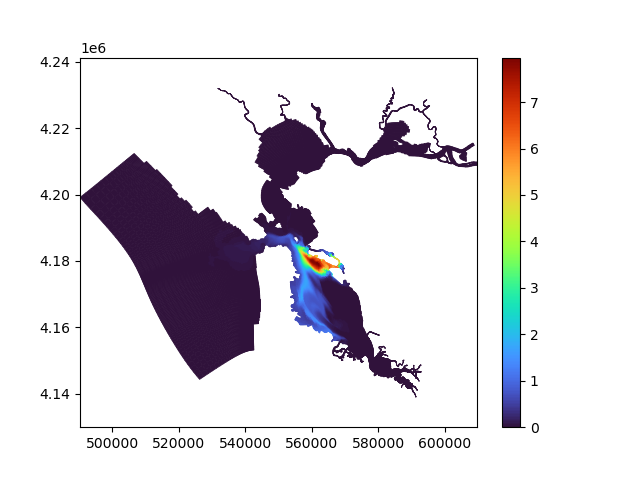

In [34]:
fig,ax=plt.subplots()
ax.set_adjustable('datalim')

scal=ds['blob'].isel(time=-1,laydim=-1).values
#scal=ds['swim'].isel(time=-1,laydim=-1).values

coll=g.plot_cells(values=scal,cmap='turbo',lw=0.5,edgecolor='face')
plt.colorbar(coll)


<IPython.core.display.Javascript object>


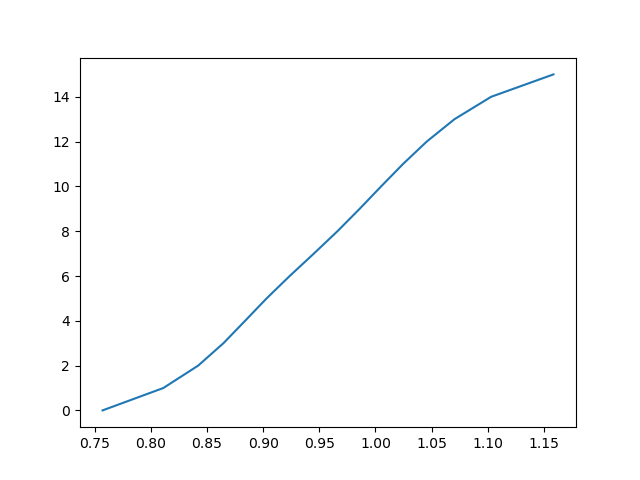

In [340]:
pnt=[568470,4158360]
c=g.select_cells_nearest(pnt)
profile=ds['swim'].isel(time=-1,nFlowElem=c)
fig,ax=plt.subplots()
ax.plot(profile,np.arange(ds.dims['laydim']))

In [350]:
ds.time.values[:4]

array(['2022-05-01T00:00:00.000000000', '2022-05-01T03:00:00.000000000',
       '2022-05-01T06:00:00.000000000', '2022-05-01T09:00:00.000000000'],
      dtype='datetime64[ns]')

In [85]:

# Run a DWAQ simulation, using original hydro and old DWAQ, but following
# the spinup period of the new DFM run. Not apples-to-apples in terms of versions,
# but should be an okay test to understand how different things might be.

# Results with integration option 15.60 and 16.62 were nearly identical.
# Arjen from Deltares suggests 21, 22, 24.
# Manual gives "ANTIDIFFUSION" as an option for 21 and 22.
# 21 and 22 are both flux corrected transport schemes 
# (21: Salezac, 22: Boris and Book)

if 1:
    configure_dwaq_new()
    # For reference:
    #   dfm_path="/chicagovol1/hpcshared/open_bay/hydro/full_res/wy2022_bloom/runs/wy2022_bloom_16layer"    
    #   dwaq_hydro=os.path.join(dfm_path, "DFM_DELWAQ_wy2022_bloom_16layer")
    #   hydro=dwaq.HydroFiles(os.path.join(dwaq_hydro,"wy2022_bloom_16layer.hyd"))
    pb=DwaqSwimAndPoint(hydro=hydro,
                        start_time=np.datetime64("2022-05-01 00:00"),
                        # HERE - check that this is slightly shorter than the hydro.
                        # I think it's getting stuck on the last step due to the 
                        # hydro ending at the exact same time.
                        # hmm - no, it's seeming like NFS issues. Stop shy anyway.
                        stop_time =np.datetime64("2022-05-12 18:00"),
                        name="dwaq_swim_point_coldstart",
                        #integration_option="16.62", # should match SFEI runs
                        integration_option="22",
                        # Match DFM output time step
                        map_time_step=30000)
    pb.run_waq_model()

INFO:root:base_path defaults to run_wy2022_16layer_dwaq_swim_point_coldstart_20220501-v015
INFO:WaqModel: start time updated from hydro: 2022-05-01T00:00:00.000000
INFO:WaqModel: stop time update from hydro: 2022-10-01T00:00:00.000000
INFO:HydroFiles:Segment depth will be inferred
INFO:WaqModel:Parameters gleaned from hydro: NamedObjects([('surf', <stompy.model.delft.waq_scenario.ParameterSpatial object at 0x7fad87962f70>), ('bottomdept', <stompy.model.delft.waq_scenario.ParameterSpatial object at 0x7fad8f0b1ee0>), ('vertdisper', <stompy.model.delft.waq_scenario.ParameterSpatioTemporal object at 0x7fac7a6f0af0>), ('tau', <stompy.model.delft.waq_scenario.ParameterSpatioTemporal object at 0x7fad8eca66a0>), ('temp', <stompy.model.delft.waq_scenario.ParameterSpatioTemporal object at 0x7fac78ec2250>), ('salinity', <stompy.model.delft.waq_scenario.ParameterSpatioTemporal object at 0x7fac597e0790>)])
INFO:WaqModel:Writing hydro data
INFO:HydroFiles:Using .bnd file, not writing out kludgey bou

In [41]:
# pb.wm.cmd_write_nc()

INFO:WaqModel:NEFIS file didn't exist. Skipping ugrid_nef()


In [43]:
# v009: integration option was 15.60
# v011: 16.62, add keywords from BGC runs.
# v012: disable vertical diffusion
ds_dwaq=xr.open_dataset("run_wy2022_16layer_dwaq_swim_point_coldstart_20220501-v009/dwaq_map.nc")

In [44]:
g_dwaq=unstructured_grid.UnstructuredGrid.read_ugrid(ds_dwaq)

In [45]:
ds_dwaq

<xarray.Dataset>
Dimensions:     (sub: 5, time: 566, layer: 16, face: 49996, node: 44184,
                 maxnode_per_face: 6, edge: 94194, node_per_edge: 2)
Coordinates:
  * sub         (sub) object 'BLOOMAlg01' 'dye1' ... 'SURF' 'TotalDepth'
  * time        (time) datetime64[ns] 2022-05-01 ... 2022-05-12T18:30:00
Dimensions without coordinates: layer, face, node, maxnode_per_face, edge,
                                node_per_edge
Data variables: (12/14)
    t_sec       (time) int32 ...
    BLOOMAlg01  (time, layer, face) float32 ...
    dye1        (time, layer, face) float32 ...
    LocalDepth  (time, layer, face) float32 ...
    SURF        (time, layer, face) float32 ...
    TotalDepth  (time, layer, face) float32 ...
    ...          ...
    node_y      (node) float64 4.151e+06 4.152e+06 ... 4.153e+06 4.153e+06
    face_node   (face, maxnode_per_face) int32 295 297 298 296 ... 43385 -1 -1
    edge_node   (edge, node_per_edge) int32 295 297 297 ... 43320 43449 43385
    bedlevel    (face) float32 -1.433e-06 -1.336e-07 ... -0.9297 -0.9297
    eta         (time, face) float32 ...
    sigma       (layer) float64 ...
Attributes:
    header:   DWAQ                                    n/a                    ...

In [46]:
ds.time.values[-1], ds_dwaq.time.values[-1]

(numpy.datetime64('2022-05-13T00:00:00.000000000'),
 numpy.datetime64('2022-05-12T18:30:00.000000000'))

<IPython.core.display.Javascript object>


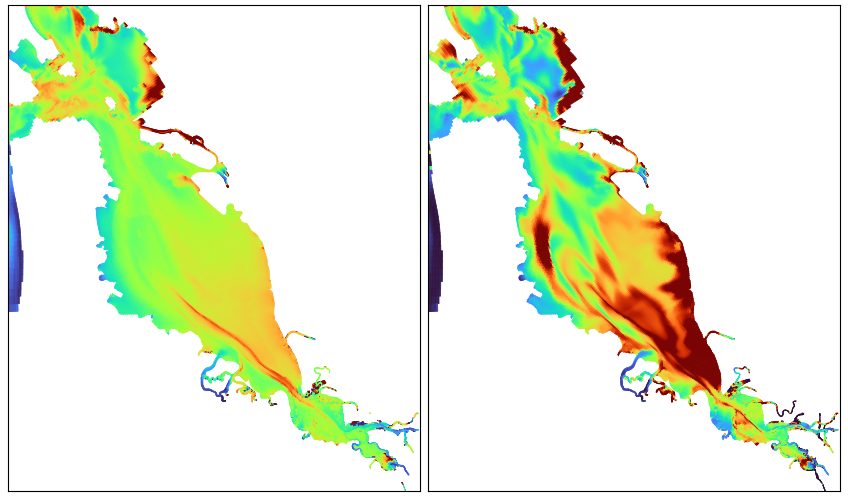

In [369]:
fig,axs=plt.subplots(1,2)

for ax in axs:
    ax.xaxis.set_visible(0)
    ax.yaxis.set_visible(0)
    ax.set_adjustable('datalim')
    
dfm_tidx=dwaq_tidx=-1 

clim=[0,2.0]

ax=axs[0]
swim_dwaq=ds_dwaq['BLOOMAlg01'].isel(time=dfm_tidx,layer=0).values
coll_dwaq=g_dwaq.plot_cells(values=swim_dwaq,cmap='turbo',lw=0.5,edgecolor='face',
                            clim=clim,ax=ax)

ax=axs[1]
swim_dfm=ds['swim'].isel(time=dfm_tidx,laydim=-1).values
coll_dfm=g.plot_cells(values=swim_dfm,cmap='turbo',lw=0.5,edgecolor='face',
                            clim=clim,ax=ax)


for ax in axs:
    ax.axis('equal')
    ax.axis((548382.9844699897, 587609.3817548773, 4145278.545893392, 4192399.4642829127))
    
fig.subplots_adjust(left=0.01,right=0.99,top=0.99,bottom=0.01,wspace=0.02)

<IPython.core.display.Javascript object>


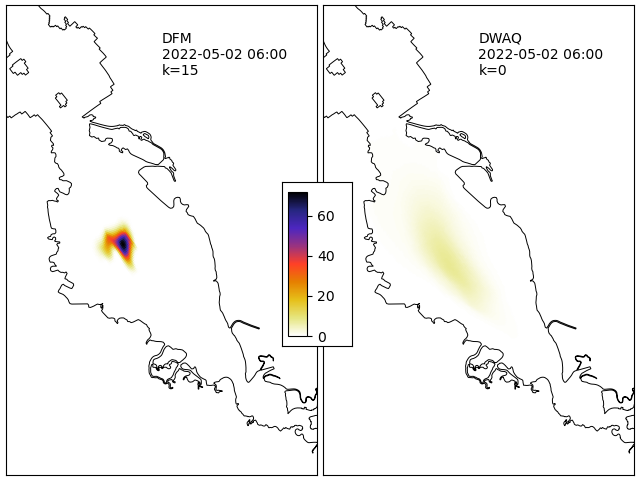

INFO:join_features:0 open strings, 16 simple polygons
INFO:join_features:Building index
INFO:UnstructuredGrid:Warning, boundary_polygon() failed using edges!  Trying polygon union method


In [79]:
# Compare the blobs.

fig,axs=plt.subplots(1,2)

for ax in axs:
    ax.xaxis.set_visible(0)
    ax.yaxis.set_visible(0)
    ax.set_adjustable('datalim')
    
cax_bg=fig.add_axes([0.44,0.28,0.11,0.34])
cax_bg.xaxis.set_visible(0)
cax_bg.yaxis.set_visible(0)

cax=fig.add_axes([0.45,0.3,0.03,0.3])

Nlayers=ds.dims['laydim']
fig.subplots_adjust(left=0.01,right=0.99,top=0.99,bottom=0.01,wspace=0.02)
poly=g.boundary_polygon()

def plot(dfm_tidx=10): 
    dfm_layer=Nlayers-1 # bed -> surface
    dfm_time="unset"
    for ax,sim,grid in zip(axs,['DFM','DWAQ'],[g,g_dwaq]):
        ax.cla()
        plot_wkb.plot_wkb(poly,facecolor='none',lw=0.7,edgecolor='k',ax=ax,zorder=4)
        if sim=='DFM':
            k=dfm_layer
            scal=ds['blob'].isel(time=dfm_tidx,laydim=k).values
            dfm_time=t=ds.time.values[dfm_tidx]
            clim=[0,scal.max()]
        else:
            k=Nlayers-(1+dfm_layer)
            dwaq_tidx=np.searchsorted(ds_dwaq.time.values,dfm_time)
            scal=ds_dwaq['dye1'].isel(time=dwaq_tidx,layer=k).values
            t=ds_dwaq.time.values[dwaq_tidx]

        coll=grid.plot_cells(values=scal,
                             #cmap='turbo',
                             cmap="CMRmap_r",
                             lw=0.5,edgecolor='face', clim=clim,ax=ax)
        t_str=utils.to_datetime(t).strftime("%Y-%m-%d %H:%M")
        ax.text(0.5,0.85,f"{sim}\n{t_str}\nk={k}",transform=ax.transAxes)
    plt.colorbar(coll,cax=cax)

    for ax in axs:
        ax.axis('equal')
        ax.axis((548382.9844699897, 587609.3817548773, 4145278.545893392, 4192399.4642829127))
    plt.draw()
    
plot()


In [72]:
plot(3)

<IPython.core.display.Javascript object>


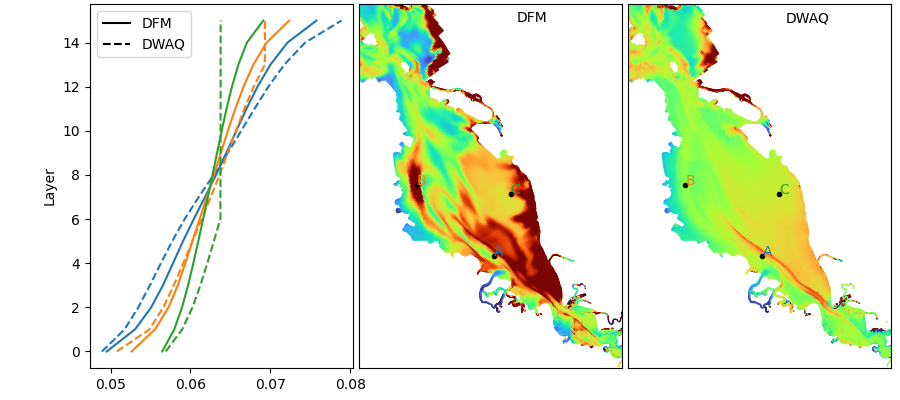

In [391]:
# Plot vertical profiles at a few points

fig,(ax_z,ax_dfm_map,ax_dwaq_map)=plt.subplots(1,3,figsize=(9,4))

pnts=[[568470,4158360],
      [557000,4169000],
      [571000,4167600]]

dfm_tidx=dwaq_tidx=-1 

#g.contourf_node_values(g.nodes['NetNode_z'],np.linspace(-25,2),ax=ax_map,
#                       extend='both',cmap='gray_r')


clim=[0,2]
ax=ax_dwaq_map
swim_dwaq=ds_dwaq['BLOOMAlg01'].isel(time=dfm_tidx,layer=0).values
coll_dwaq=g_dwaq.plot_cells(values=swim_dwaq,cmap='turbo',lw=0.5,edgecolor='face',
                            clim=clim,ax=ax)

ax=ax_dfm_map
swim_dfm=ds['swim'].isel(time=dfm_tidx,laydim=-1).values
coll_dfm=g.plot_cells(values=swim_dfm,cmap='turbo',lw=0.5,edgecolor='face',
                            clim=clim,ax=ax)

ax_maps=[ax_dfm_map,ax_dwaq_map]
for ax_map,label in zip(ax_maps,['DFM','DWAQ']):
    ax_map.axis('equal')
    ax_map.xaxis.set_visible(0)
    ax_map.yaxis.set_visible(0)
    ax_map.axis((548382.9844699897, 587609.3817548773, 4145278.545893392, 4192399.4642829127))
    ax_map.text(0.6,0.98,label,transform=ax_map.transAxes,va='top')


normalize=True

for i,pnt in enumerate(pnts):
    # Plot DFM profile
    c=g.select_cells_nearest(pnt)
    profile=ds['swim'].isel(time=dfm_tidx,nFlowElem=c).values
    if normalize:
        profile = profile/profile.sum()
        
    ls=ax_z.plot(profile,np.arange(ds.dims['laydim']))
    color=ls[0].get_color()

    c=g_dwaq.select_cells_nearest(pnt)
    profile=ds_dwaq['BLOOMAlg01'].isel(time=dwaq_tidx,face=c).values
    if normalize:
        profile=profile / profile.sum()
    
    ax_z.plot(profile[::-1], np.arange(ds_dwaq.dims['layer']),color=color,ls='--')    
    
    label="ABCDEFGHIJKL"[i]
    for ax_map in ax_maps:
        ax_map.text(pnt[0],pnt[1],label,color=color)
        ax_map.plot(pnt[0],pnt[1],'k.')

ax_z.plot([np.nan],[np.nan],'k-',label='DFM')
ax_z.plot([np.nan],[np.nan],'k--',label='DWAQ')

ax_z.set_ylabel('Layer')
ax_z.legend(loc='upper left')
fig.subplots_adjust(top=0.99,right=0.99,left=0.1,bottom=0.08,wspace=0.02)

In [86]:
ls

BLOOMAlg01-0mpd-daily-avg.mp4
BLOOMAlg01-0mpd-daily-int.mp4
BLOOMAlg01-0mpd-daily-triptych.mp4
BLOOMAlg02-5.0mpd-daily-avg.mp4
BLOOMAlg02-5.0mpd-daily-int.mp4
BLOOMAlg02-5.0mpd-daily-triptych.mp4
BLOOMAlg03-15.0mpd-daily-avg.mp4
BLOOMAlg03-15.0mpd-daily-int.mp4
BLOOMAlg03-15.0mpd-daily-triptych.mp4
BLOOMALG04-15mpd-daily.mp4
BLOOMAlg04-30mpd-daily-avg.mp4
BLOOMAlg04-30mpd-daily-int.mp4
BLOOMAlg04-30mpd-daily-triptych.mp4
BLOOMAlg04-instant.mp4
BLOOMAlg05-50mpd-daily-avg.mp4
BLOOMAlg05-50mpd-daily-int.mp4
BLOOMAlg05-50mpd-daily-triptych.mp4
bloom_timing.ipynb
cache/
depth-avg-growth-rates.nc
frames-growth-BLOOMAlg04/
frames-growth-daily-avg-BLOOMAlg01/
frames-growth-daily-avg-BLOOMAlg02/
frames-growth-daily-avg-BLOOMAlg03/
frames-growth-daily-avg-BLOOMAlg04/
frames-growth-daily-avg-BLOOMAlg05/
frames-growth-daily-BLOOMAlg04/
frames-growth-daily-int-BLOOMAlg01/
frames-growth-daily-int-BLOOMAlg02/
frames-growth-daily-int-BLOOMAlg03/
frames-growth-daily-int-BLOOMAlg04/
frames-growth-daily-